In [209]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Relu neurons

In [210]:
d = 2 # dimension of space
M = 5 # number of neurons for generation

In [211]:
def relu(x):
    if x >= 0:
        return x
    return 0

In [212]:
def drelu(x):
    if x >= 0:
        return 1
    return 0

In [213]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        norm = 1e-1 * np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        self.a = a / norm
        self.w = w / norm
        self.b = b / norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [214]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y

In [215]:
gen_net = Network(M)

Initialize new network with parameters on the sphere.

In [216]:
net = Network(20)
X, Y = gen_net.gen_sample(5000)

Train it using SGD

In [217]:
net.sgd_train(X, Y, tau = 0.1, batch = 2, epochs = 1)

epoch 0 : 0.149020305273103


0.149020305273103

Make several experiments for different values of $m$

In [218]:
np.logspace(0.6, 2.0, 15, base = 10.)

array([  3.98107171,   5.01187234,   6.30957344,   7.94328235,
        10.        ,  12.58925412,  15.84893192,  19.95262315,
        25.11886432,  31.6227766 ,  39.81071706,  50.11872336,
        63.09573445,  79.43282347, 100.        ])

In [221]:
#m_range = np.logspace(0.6, 2.0, 15, base = 10.)
#m_range = [int(b) for b in m_range]

m_range = range(3, 15)
rep = 1
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    Xt, Yt = gen_net.gen_sample(1000)
    for mi in range(len(m_range)):
        m = m_range[mi]
        net = Network(m)
        X, Y = gen_net.gen_sample(100000)
        train_loss = net.sgd_train(X, Y, tau = 0.1, batch = 4, epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)




  0%|          | 0/1 [00:00<?, ?it/s]

train 0.35810977455738147
test 0.43944085491278434
3
train 0.020248989602253225
test 0.02020614815246202
4
train 0.2751051225633012
test 0.34369334886764896
5
train 0.021199814244007804
test 0.022945476156522798
6
train 0.08423071477262202
test 0.09381757113335042
7
train 0.0059929360385136245
test 0.005126994192743836
8
train 0.05498290785977253
test 0.06259369692898735
9
train 0.00321571946149148
test 0.003126764811508682
10
train 0.0011464289617527303
test 0.0009615524711321759
11
train 0.0012170329483965157
test 0.0011012558966345249
12
train 0.004456056405406398
test 0.004096810467217408
13





100%|██████████| 1/1 [03:35<00:00, 215.22s/it]




train 0.00485472729832328
test 0.005294374616414663
14


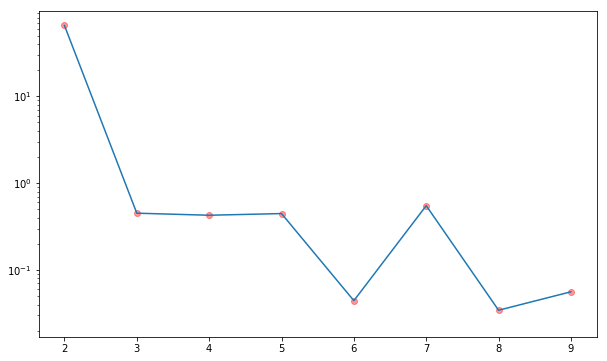

In [220]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='r', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)))
plt.yscale('log')
#plt.xscale('log')
#plt.xlim((2.8, 105))
#plt.ylim((1e-6, 1))
plt.show()

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time